In [1]:
import cv2
import os
import numpy as np
import random
import shutil
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [2]:
os.listdir('dataset')

['geblek-renteng',
 'gentongan',
 'liong',
 'mega-mendung',
 'parang',
 'sekar-jagad',
 'sidomukti',
 'tambal',
 'truntum',
 'tujuh-rupa']

In [3]:
def resize_image(image, target_size=(224, 224)):
    resized_image = cv2.resize(image, target_size)
    return resized_image

In [4]:
def main():
    input_base_path = 'dataset/'
    output_base_path = 'output_dataset/'

    for folder_name in os.listdir(input_base_path):
        input_folder_path = os.path.join(input_base_path, folder_name)
        output_folder_path = os.path.join(output_base_path, folder_name)

        os.makedirs(output_folder_path, exist_ok=True)

        for filename in os.listdir(input_folder_path):
            input_image_path = os.path.join(input_folder_path, filename)
            output_image_path = os.path.join(output_folder_path, filename)

            if os.path.isfile(input_image_path):
                try:
                    image = cv2.imread(input_image_path)
                    resized_image = resize_image(image)

                    cv2.imwrite(output_image_path, resized_image)
                except Exception as e:
                    print(f"Error resizing image {filename} pada folder {folder_name}: {str(e)}")

    print("Image resizing completed.")

In [5]:
if __name__ == "__main__":
    main()

Image resizing completed.


In [6]:
def min_max_normalize_image(image):
    image = image.astype('float32')

    min_val = np.min(image)
    max_val = np.max(image)
    if min_val == max_val:
        return np.zeros_like(image)
    else:
        normalized_image = (image - min_val) / (max_val - min_val)
        return normalized_image

In [7]:
def main():
    input_base_path = 'output_dataset/'

    for folder_name in os.listdir(input_base_path):
        input_folder_path = os.path.join(input_base_path, folder_name)

        for filename in os.listdir(input_folder_path):
            input_image_path = os.path.join(input_folder_path, filename)

            if os.path.isfile(input_image_path):
                try:
                    image = cv2.imread(input_image_path)

                    normalized_image = min_max_normalize_image(image)

                    cv2.imwrite(input_image_path, normalized_image * 255) 
                except Exception as e:
                    print(f"Error normalizing image {filename} pada folder {folder_name}: {str(e)}")

    print("Image normalization completed.")

if __name__ == "__main__":
    main()

Image normalization completed.


In [8]:
def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    l_channel, a_channel, b_channel = cv2.split(lab_image)

    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    enhanced_l_channel = clahe.apply(l_channel)

    clahe_image = cv2.merge((enhanced_l_channel, a_channel, b_channel))

    enhanced_image = cv2.cvtColor(clahe_image, cv2.COLOR_LAB2BGR)

    return enhanced_image

In [9]:
def main():
    input_base_path = 'output_dataset'
    
    for folder_name in os.listdir(input_base_path):
        input_folder_path = os.path.join(input_base_path, folder_name)

        for filename in os.listdir(input_folder_path):
            input_image_path = os.path.join(input_folder_path, filename)

            if os.path.isfile(input_image_path):
                try:
                    image = cv2.imread(input_image_path)
                    enhanced_image = apply_clahe(image)
                    cv2.imwrite(input_image_path, enhanced_image)
                except Exception as e:
                    print(f"Error enhancing image {filename} pada folder {folder_name}: {str(e)}")

    print("Contrast enhancement with CLAHE completed.")

In [10]:
if __name__ == "__main__":
    main()

Contrast enhancement with CLAHE completed.


In [11]:
def augment_images(input_folder, num_images=10):
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),  
        iaa.Affine(rotate=(-20, 20)),  
        iaa.GaussianBlur(sigma=(0, 1.0)), 
        iaa.AdditiveGaussianNoise(scale=(0, 0.05 * 255)),  
        iaa.Multiply((0.8, 1.2), per_channel=0.2), 
        iaa.LinearContrast((0.5, 2.0), per_channel=0.5),  
    ])

    for folder_name in os.listdir(input_folder):
        input_folder_path = os.path.join(input_folder, folder_name)
        if not os.path.isdir(input_folder_path):
            continue

        image_files = [f for f in os.listdir(input_folder_path) if os.path.isfile(os.path.join(input_folder_path, f))]

        selected_files = random.sample(image_files, min(num_images, len(image_files)))

        for filename in selected_files:
            input_image_path = os.path.join(input_folder_path, filename)
            try:
                image = cv2.imread(input_image_path)

                images_aug = [seq(image=image) for _ in range(num_images)]

                for idx, image_aug in enumerate(images_aug):
                    output_image_path = os.path.join(input_folder_path, f"{filename.split('.')[0]}_{idx}.jpg")
                    cv2.imwrite(output_image_path, image_aug)

                os.remove(input_image_path)
            except Exception as e:
                print(f"Error saat melakukan augmentasi untuk gambar {filename} di folder {folder_name}: {str(e)}")

    print("Augmentasi gambar selesai.")

input_folder_path = 'output_dataset'

augment_images(input_folder_path, num_images=10)

Augmentasi gambar selesai.


In [12]:
path = 'output_dataset/'
split_path = 'split_dataset/'

train_path = os.path.join(split_path, 'train')
test_path = os.path.join(split_path, 'test')
val_path = os.path.join(split_path, 'val')
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)

In [13]:
for subfolder in os.listdir(path):
    subfolder_path = os.path.join(path, subfolder)
    
    if os.path.isdir(subfolder_path):
        train_subfolder_path = os.path.join(train_path, subfolder)
        test_subfolder_path = os.path.join(test_path, subfolder)
        val_subfolder_path = os.path.join(val_path, subfolder)
        os.makedirs(train_subfolder_path, exist_ok=True)
        os.makedirs(test_subfolder_path, exist_ok=True)
        os.makedirs(val_subfolder_path, exist_ok=True)
        
        file_list = os.listdir(subfolder_path)
        num_files = len(file_list)
        
        num_train = int(0.7 * num_files)
        num_test = int(0.2 * num_files)
        num_val = num_files - num_train - num_test
        
        random.shuffle(file_list)
        
        for i, file_name in enumerate(file_list):
            old_path = os.path.join(subfolder_path, file_name)
            
            if i < num_train:
                new_path = os.path.join(train_subfolder_path, file_name)
            elif i < num_train + num_test:
                new_path = os.path.join(test_subfolder_path, file_name)
            else:
                new_path = os.path.join(val_subfolder_path, file_name)
            
            shutil.copy(old_path, new_path)  
            
print("File-file berhasil dibagi ke dalam folder train, test, dan val.")

File-file berhasil dibagi ke dalam folder train, test, dan val.


In [14]:
train_dir = 'split_dataset/train/'
val_dir = 'split_dataset/val/'
test_dir = 'split_dataset/test/'

In [15]:
os.listdir(train_dir)

['geblek-renteng',
 'gentongan',
 'liong',
 'mega-mendung',
 'parang',
 'sekar-jagad',
 'sidomukti',
 'tambal',
 'truntum',
 'tujuh-rupa']

In [16]:
#Hyperparameter
image_size = (224, 224)
batch_size = 32
epochs = 25
learning_rate = 0.0001

In [17]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 980 images belonging to 10 classes.


In [18]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 140 images belonging to 10 classes.


In [19]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 280 images belonging to 10 classes.


In [20]:
base_model = MobileNetV2(weights='imagenet', include_top=False)

# Build the model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\USER\AppData\Local\Temp\ipykernel_1480\2261410678.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False)


In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [22]:
# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/25


c:\Users\USER\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 421ms/step - accuracy: 0.5580 - loss: 1.6185 - val_accuracy: 0.8429 - val_loss: 0.5261 - learning_rate: 0.0010
Epoch 2/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 266ms/step - accuracy: 0.9420 - loss: 0.1604 - val_accuracy: 0.8929 - val_loss: 0.3606 - learning_rate: 0.0010
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 264ms/step - accuracy: 0.9849 - loss: 0.0578 - val_accuracy: 0.8929 - val_loss: 0.2988 - learning_rate: 0.0010
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 264ms/step - accuracy: 0.9934 - loss: 0.0321 - val_accuracy: 0.9071 - val_loss: 0.2756 - learning_rate: 0.0010
Epoch 5/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 266ms/step - accuracy: 0.9960 - loss: 0.0203 - val_accuracy: 0.9143 - val_loss: 0.2820 - learning_rate: 0.0010
Epoch 6/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 269ms/step - accuracy: 0.9997 - loss: 0.0193 - val_accuracy: 0.9286 - val_loss: 0.2499 - learning_rate: 0.0010
Epoch 7/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 266ms/step - accuracy: 0.9991 - loss: 0.0103 - val_accura

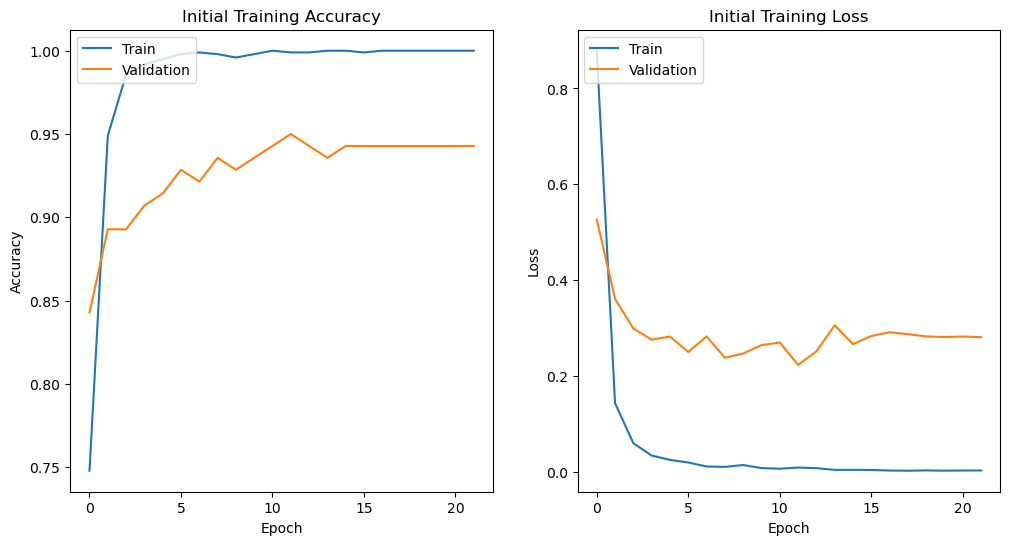

In [23]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Initial Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Initial Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [24]:
for layer in base_model.layers[-30:]:
    layer.trainable = True

In [25]:
# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=learning_rate * 0.1), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history_fine_tune = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 521ms/step - accuracy: 0.7717 - loss: 0.7078 - val_accuracy: 0.9429 - val_loss: 0.2209 - learning_rate: 1.0000e-05
Epoch 2/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 360ms/step - accuracy: 0.8499 - loss: 0.4139 - val_accuracy: 0.9429 - val_loss: 0.2348 - learning_rate: 1.0000e-05
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 359ms/step - accuracy: 0.8852 - loss: 0.3713 - val_accuracy: 0.9286 - val_loss: 0.2600 - learning_rate: 1.0000e-05
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 357ms/step - accuracy: 0.9128 - loss: 0.2572 - val_accuracy: 0.9286 - val_loss: 0.2761 - learning_rate: 1.0000e-05
Epoch 5/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 357ms/step - accuracy: 0.9327 - loss: 0.2159 - val_accuracy: 0.9286 - val_loss: 0.2848 - learning_rate: 1.0000e-05
Epoch 6/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 359ms/step - accuracy: 0.9588 - loss: 0.1404 - val_accuracy: 0.9286 - val_loss: 0.3011 - learning_rate: 1.0000e-05
Epoch 7/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 358ms/step - acc

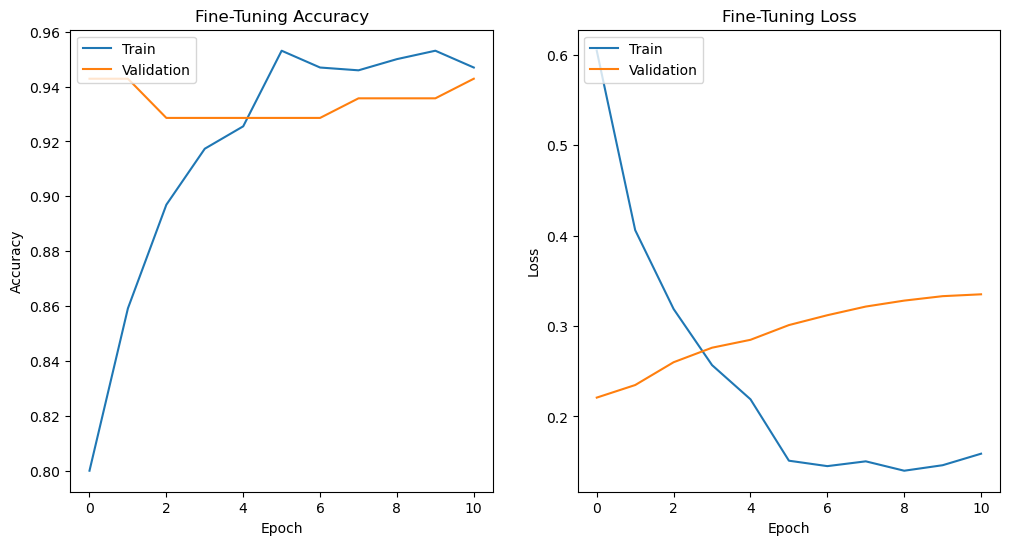

In [26]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_fine_tune.history['accuracy'])
plt.plot(history_fine_tune.history['val_accuracy'])
plt.title('Fine-Tuning Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_fine_tune.history['loss'])
plt.plot(history_fine_tune.history['val_loss'])
plt.title('Fine-Tuning Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [27]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f'Test accuracy: {test_acc}')


9/9 - 3s - 349ms/step - accuracy: 0.9393 - loss: 0.2324
Test accuracy: 0.9392856955528259


In [28]:
# Get class labels
class_labels = list(test_generator.class_indices.keys())

In [29]:
# Make predictions on the test data
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 384ms/step


In [30]:
true_classes = test_generator.classes

cm = confusion_matrix(true_classes, predicted_classes)

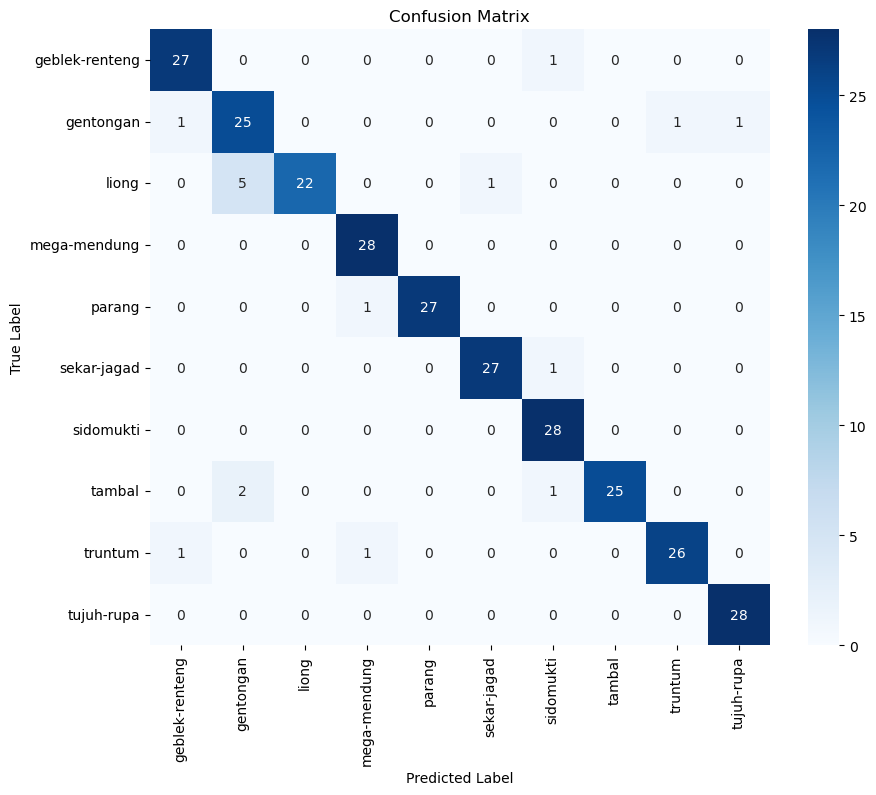

                precision    recall  f1-score   support

geblek-renteng       0.93      0.96      0.95        28
     gentongan       0.78      0.89      0.83        28
         liong       1.00      0.79      0.88        28
  mega-mendung       0.93      1.00      0.97        28
        parang       1.00      0.96      0.98        28
   sekar-jagad       0.96      0.96      0.96        28
     sidomukti       0.90      1.00      0.95        28
        tambal       1.00      0.89      0.94        28
       truntum       0.96      0.93      0.95        28
    tujuh-rupa       0.97      1.00      0.98        28

      accuracy                           0.94       280
     macro avg       0.94      0.94      0.94       280
  weighted avg       0.94      0.94      0.94       280



In [31]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

In [32]:
# Calculate precision, recall, and f1-score
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Precision: 0.9441609541171555
Recall: 0.9392857142857143
F1 Score: 0.9392782346462569


In [33]:
model.save("model.h5")